In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv
import os
from PIL import Image
import pickle

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Adding gaussian Noise:
class GaussianNoise():
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean
        self.std = std

    def __call__(self, img):
        img = np.array(img) / 255.0  # Normalize to [0,1]
        noise = np.random.normal(self.mean, self.std, img.shape)
        noisy_img = np.clip(img + noise, 0, 1)  # Clip to valid range
        noisy_img = (noisy_img * 255).astype(np.uint8)  # Convert back to uint8

        # **Ensure 3 channels for PIL Image**
        if noisy_img.ndim == 2:
            noisy_img = np.stack([noisy_img] * 3, axis=-1)  # Convert (H, W) → (H, W, 3)

        return Image.fromarray(noisy_img)  # Convert back to PIL image


# Adding Salt And Pepper Noise:
class SaltPepperNoise():
  def __init__(self,prob):
    self.prob = prob

  def __call__(self,img):
    img = np.array(img)
    h,w,c = img.shape

    mask = np.random.rand(h,w)
    img[mask<self.prob/2] = 0
    img[mask>1-self.prob/2] = 255
    return Image.fromarray((img).astype(np.uint8))

In [ ]:
resnet = models.resnet50(pretrained = True)
#model.avgpool = identity()
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 2)
resnet = resnet.to(device)
print(resnet)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
Transforms = transforms.Compose([transforms.Resize((224,224)),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                 transforms.RandomVerticalFlip(p=0.5),
                                 transforms.RandomRotation(degrees=10),
                                 GaussianNoise(mean = 0,std = 0.05),
                                 transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_transforms = transforms.Compose([transforms.Resize((224,224)),
                                     transforms.ToTensor()])

In [ ]:
train_pth = ImageFolder('/content/drive/MyDrive/Crop Survailance/Plant Pos/Train',transform = Transforms)
val_pth = ImageFolder('/content/drive/MyDrive/Crop Survailance/Plant Pos/Val',transform = val_transforms)

train_loader = DataLoader(train_pth,batch_size = 16,shuffle = True)
val_loader = DataLoader(val_pth,batch_size = 16,shuffle = True)

In [8]:
num_epochs = 8

# Model train :
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(),lr = 0.01,weight_decay = 1e-3)

resnet.train()

for epoch in range(num_epochs) :
  running_loss = 0
  for img,label in train_loader :
    img = img.to(device)
    label = label.to(device)

    output = resnet(img)
    loss = criterion(output,label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  print(f'Epochs : {(epoch+1)}/{num_epochs} , Loss : {running_loss/len(train_loader):.4f}')

print("Training Complete")

Epochs : 1/8 , Loss : 1.7434
Epochs : 2/8 , Loss : 0.5540
Epochs : 3/8 , Loss : 0.3813
Epochs : 4/8 , Loss : 0.7055
Epochs : 5/8 , Loss : 0.3209
Epochs : 6/8 , Loss : 0.3736
Epochs : 7/8 , Loss : 0.2540
Epochs : 8/8 , Loss : 0.2283
Training Complete


In [ ]:
#Evaluation :

resnet.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(cuda), labels.to(cuda)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

In [16]:
# Image splitting :
def image_split(img_path) :
  # Load image (750x750x3)
  # Patch size
  img = cv.cvtColor(cv.imread(img_path),cv.COLOR_BGR2RGB)
  img = cv.resize(img,(750,750))
  patch_size = 250

  # Extract patches
  patches = []
  for i in range(0, 750, patch_size):  # Rows
      for j in range(0, 750, patch_size):  # Columns
          patch = img[i:i+patch_size, j:j+patch_size]  # Slice image
          patches.append(patch)
  #img_show(patches)
  return patches,img

In [17]:
#img = mpimg.imread('/content/drive/MyDrive/Crop Survailance/Train/Plant/IMG-20241222-WA0126.jpg')
def img_show(img_arr):
  fig,axes = plt.subplots(3,3,figsize = (6,6))

  axes[0,0].imshow(img_arr[0])
  axes[0,1].imshow(img_arr[1])
  axes[0,2].imshow(img_arr[2])
  axes[1,0].imshow(img_arr[3])
  axes[1,1].imshow(img_arr[4])
  axes[1,2].imshow(img_arr[5])
  axes[2,0].imshow(img_arr[6])
  axes[2,1].imshow(img_arr[7])
  axes[2,2].imshow(img_arr[8])

  plt.tight_layout()

#image_split('/content/drive/MyDrive/Crop Survailance/Train/Plant/IMG20250308091720.jpg')

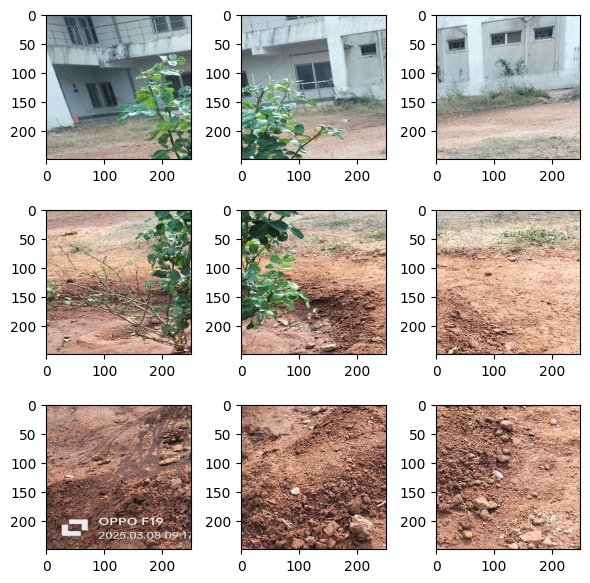

In [ ]:
img_arr,image = image_split('/content/drive/MyDrive/Crop Survailance/Train/Plant/IMG20250308091720.jpg')

In [25]:
def l_r(pred) :
  c = {1:0,2:0,3:0}
  for i in range(3) :
    count = 0
    for p in pred :
      if p in [1,2,3]:
        c[1] += 1
      elif p in [4,5,6]:
        c[2] += 1
      elif p in [7,8,9]:
        c[3] += 1
  m = max(c.values())
  return c,m

In [26]:
labels = os.listdir('/content/drive/MyDrive/Crop Survailance/Plant Pos/Val')
for label in labels :
  for im in os.listdir(os.path.join('/content/drive/MyDrive/Crop Survailance/Plant Pos/Val',label)) :
    i_pth = os.path.join('/content/drive/MyDrive/Crop Survailance/Plant Pos/Val',label,im)
    img = Image.open(i_pth)
    img = val_transforms(img)
    img = img.unsqueeze(0)
    img = img.to(device)
    output = resnet(img)
    predicted = torch.argmax(output,1)
    if labels[predicted] == 'Plant' :
      patches,img = image_split(i_pth)
      pred = dict()
      for i,im in enumerate(patches) :
        im = Image.fromarray(im)
        im = Transforms(im)
        im = im.unsqueeze(0)
        im = im.to(device)
        output = resnet(im)
        predicted = torch.argmax(output,1)
        pred[i+1] = labels[predicted]
      plant_pred = [i for i in pred if pred[i] == 'Plant']
      count,m = l_r(plant_pred)
      if count[1] == m:
        print("Plant located on the left side of the image")
        angle = -45
      elif count[2] == m:
        print("Plant is in front of you")
        angle = 0
      elif count[3] == m:
        print("plant located on the right side of the image")
        angle = 45

Plant located on the left side of the image


In [ ]:
resnet.eval()
with torch.no_grad():
  img = Image.open('/content/drive/MyDrive/Crop Survailance/Train/Plant/IMG20250308091609.jpg')
  img = Transforms(img)
  img = img.unsqueeze(0)
  output = resnet(img)
  predicted = torch.argmax(output,1)
  print(labels[predicted])

In [13]:
with open('resnet.pkl','wb') as file:
  pickle.dump(resnet,file)

In [14]:
torch.save(resnet,'resnet.pth')

In [15]:
torch.save(resnet.state_dict(),'resnet_weights.pth')